# Intro to Poke: Polarization Ray Tracing

The first physics submodule of poke is for polarization ray tracing (PRT). All of the physics are done in the `poke.polarization` module, and everything else is just ray data. PRT is an expression of the Fresnel Equations for thin-film polarization in three dimensions. This allows for the propagation of polarization-dependent performance through a ray trace of an optical system

The desireable data product is a Jones Pupil, which is the 3x3 PRT matrix rotated into a local coordinate system. Poke does this using the double pole coordinate system descibed in Chipman, Lam, and Young (2018) Chapter 11.4. This coordinate system is robust to polarization singularities that arise in using the s- and p- basis.

## Initializing a Rayfront as Polarized
So you want a Jones pupil of an optical system, this section will describe how we set up optical system parameters for a `Rayfront` to be built. First, we start with the system properties:
- path to sequential ray trace file
- thin film information

In [10]:
n_film = 0.04 + 1j*7.1155 # Ag at 1um from Johnson and Christy 1972 refractiveindex.info
pth_to_lens = '/Users/ashcraft/Desktop/poke/test_files/hubble_test.len'

That wasn't too bad. Note that we only specify a thin film index, which means that the software assumes the substrate is made of entirely silver. Poke also supports thin film stacks, but we will cover that in another tutorial. Now we must specify the surface data. Poke handles surface data with dictionaries as a low-level "user interface", and stores them in a list in the order that they appear in the raytrace.

In [2]:
# The Primary Mirror
s1 = {
    "surf" : 1,         # surface number in zemax
    "coating" : n_film, # refractive index of surface
    "mode" : "reflect"  # compute in reflection ("reflect") or transmission ("transmit")
}

# The Secondary Mirror
s2 = {
    "surf" : 2,
    "coating" : n_film,
    "mode" : "reflect"
}

surflist = [s1,s2]

Now that we have the surface information, we can initialize a `Rayfront` and pass this surface data to it. When ray tracing with CODE V files, it is presently necessary to slightly undersize the normalized pupil radius, so that we don't get vignetting errors.

In [11]:
from poke.poke_core import Rayfront

# rayfront parameters
number_of_rays = 20 # across the entrance pupil
wavelength = 1e-6
pupil_radius = 1.2 # semi-aperture of Hubble
max_field_of_view = 0.08 # degrees

rays = Rayfront(number_of_rays,wavelength,pupil_radius,max_field_of_view,normalized_pupil_radius=0.99,circle=True)

norm fov =  [0. 0.]
base ray shape  (4, 276)


Now we have a standard Rayfront, which is just a bundle of un-traced rays now. To enable the physical optics capabilities, we need to call the `Rayfront.as_polarized()` method and pass it the surface list.

In [12]:
rays.as_polarized(surflist)

Then we can propagate it through the optical system with the `rays.trace_rayset()` method by supplying the path specified earlier

In [13]:
rays.trace_rayset(pth_to_lens)

res /Users/ashcraft/Desktop/poke/test_files/hubble_test.len
CODE V warning: Warning:   Buffer number 0 does not exist.  Nothing deleted. 
CODE V warning: Warning:   Solves may be affected by a change in the reference wavelength 
global coordinate reference set to surface 1
number of surfaces =  3
[{'surf': 1, 'coating': (0.04+7.1155j), 'mode': 'reflect'}, {'surf': 2, 'coating': (0.04+7.1155j), 'mode': 'reflect'}]
1 Raysets traced through 2 surfaces


Now the rays have position and angle. This tells us a little bit about how `Rayfronts` are constructed. They have some attribute `Rayfront._Data` that holds on to the coordinate `_`. The following are accessible:
- xData: position in x axis
- yData: position in y axis
- zData: position in z axis
- lData: direction cosine in x axis
- mData: direction cosine in y axis
- nData: direction cosine in z axis
- l2Data: surface normal direction cosine in x axis
- m2Data: surface normal direction cosine in x axis
- n2Data: surface normal direction cosine in x axis

Each of these are numpy arrays which have shape [raybundle,surface,coordinate]. We can plot the position and direction cosines on the primary mirror:

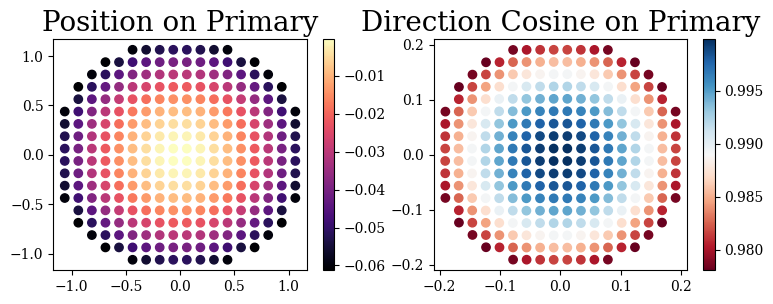

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.title('Position on Primary')
plt.scatter(rays.xData[0,0],rays.yData[0,0],c=rays.zData[0,0])
plt.colorbar()
plt.subplot(122)
plt.title('Direction Cosine on Primary')
plt.scatter(rays.lData[0,0],rays.mData[0,0],c=rays.nData[0,0],cmap='RdBu')
plt.colorbar()
plt.show()

Turns out all we need is angle of incidence, direction cosines, and refractive index data to compute the polarized exit pupil. If your final axis isn't aligned with the z-axis this is slightly more involved but for now let's keep it simple:

In [15]:
rays.compute_jones_pupil()

And we can use poke's built-in plotting routine to display it. Turns out Silver is pretty good in the infrared!

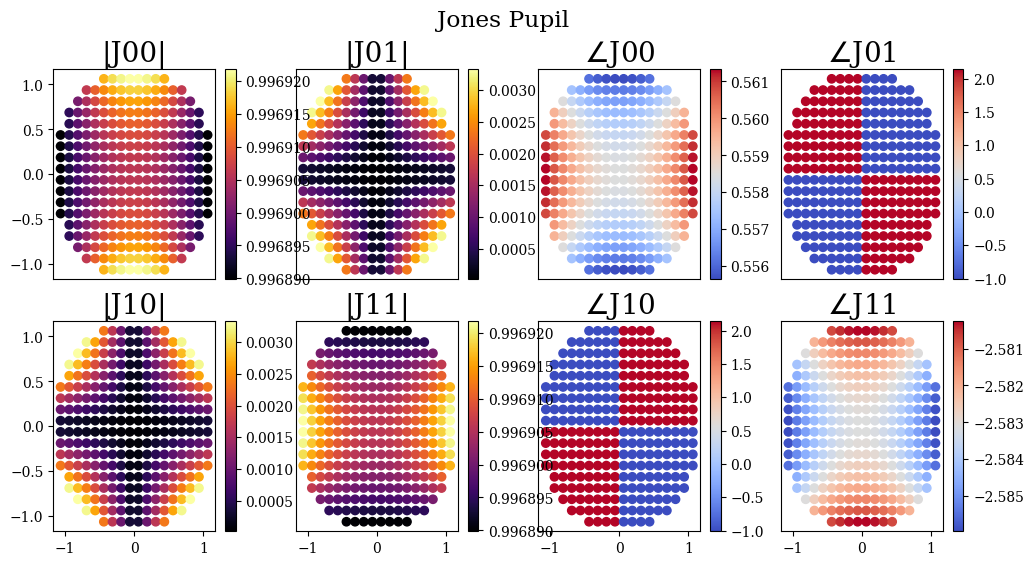

In [17]:
import poke.plotting as plot
plot.jones_pupil(rays)